In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [3]:
n_samples = 100000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [4]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [5]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [6]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

In [10]:
rewards = [10,1]
rewards[:-1]

[10]

In [11]:
np.quantile([10,1], 0.025)

1.225

In [12]:
total_reward = 0
num_choices = len(choices)
sample_count = [0 for i in range(num_choices)]
sample_rewards = [0 for i in range(num_choices)]
sample_mean = [0.0 for i in range(num_choices)]
sample_var = [0.0 for i in range(num_choices)]
arm_rewards = {0: [], 1:[], 2:[]}
rewards = []
cum_rewards = []
var_multiplier = 5
n_consecutive_list = [] # this list is to check whether
list_iteration_results = []
num_consec_elem = 5

for n, elem in enumerate(list_distributions):
    dist_type = elem
    distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
    print("\n")
    print("Iteration:", n)
    theta = {}
    for i in range(len(choices)):
        if sample_count[i] >= 2:
            theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
            print(choices_names[i],"Theta", theta[i])

        else:
            print("Less than two values for",choices_names[i])
            theta[i] = uniform.rvs(loc=0, scale=1)
            print(choices_names[i],"Theta", theta[i])

    choice = np.argmin([theta[i] for i in range(len(choices))])
    alg = choices[choice]
    alg_name = choices_names[choice]
    start_time = time.perf_counter()
    sorted_dist = alg(distribion[dist_type])
    reward = ((time.perf_counter() - start_time))*(1)
    print("\n")
    print("Chosen algorithm is: ", alg_name, "with reward:", reward)
    arm_rewards[choice].append(reward)
    sample_count[choice] += 1
    sample_rewards[choice] += reward
    sample_mean[choice] = np.mean(arm_rewards[choice])
    sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
    print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
    total_reward += reward
    rewards.append(reward)
    cum_rewards.append(sum(rewards)/len(rewards))
    if len(arm_rewards[choice])>10:
        if reward < np.quantile(arm_rewards[choice][:-1], 0.025) or reward > np.quantile(arm_rewards[choice][:-1], 0.975):
            n_consecutive_list.append(n)
            if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                print("RESTART EXPERIMENT")
                list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                sample_count = [0 for i in range(num_choices)]
                sample_rewards = [0 for i in range(num_choices)]
                sample_mean = [0.0 for i in range(num_choices)]
                sample_var = [0.0 for i in range(num_choices)]
                arm_rewards = {0: [], 1:[], 2:[]}
                rewards = []
                cum_rewards = []
                n_consecutive_list = []

list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.39183629055205293
Less than two values for merge_sort
merge_sort Theta 0.6378882862262868
Less than two values for heap_sort
heap_sort Theta 0.6384706624075559


Chosen algorithm is:  quick_sort with reward: 0.02107870000000034
Sample mean is:  0.02107870000000034 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.5263999359728782
Less than two values for merge_sort
merge_sort Theta 0.220295429014585
Less than two values for heap_sort
heap_sort Theta 0.3831177399245149


Chosen algorithm is:  merge_sort with reward: 0.018005300000002222
Sample mean is:  0.018005300000002222 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.9958365764378911
Less than two values for merge_sort
merge_sort Theta 0.31342073304990914
Less than two values for heap_sort
heap_sort Theta 0.18429910961133156


Chosen algorithm is:  heap_sort with reward: 0.02

Iteration: 26
quick_sort Theta 0.013907303398091542
merge_sort Theta 0.015281140361582506
Less than two values for heap_sort
heap_sort Theta 0.6075556770046401


Chosen algorithm is:  quick_sort with reward: 0.015642400000000833
Sample mean is:  0.015367668749999952 Sample variance is: 3.120010788399398e-06


Iteration: 27
quick_sort Theta 0.01516542389385407
merge_sort Theta 0.01569974216310334
Less than two values for heap_sort
heap_sort Theta 0.6506535265532715


Chosen algorithm is:  quick_sort with reward: 0.015639300000000134
Sample mean is:  0.015383647058823492 Sample variance is: 2.9405656436687294e-06


Iteration: 28
quick_sort Theta 0.014824566980125695
merge_sort Theta 0.019501792847461005
Less than two values for heap_sort
heap_sort Theta 0.7042197688439331


Chosen algorithm is:  quick_sort with reward: 0.015590299999999502
Sample mean is:  0.015395127777777715 Sample variance is: 2.7794416031181326e-06


Iteration: 29
quick_sort Theta 0.01642875098902318
merge_sort Theta

Sample mean is:  0.015080679999999269 Sample variance is: 1.477698521099906e-06


Iteration: 60
quick_sort Theta 0.014395448136008555
merge_sort Theta 0.01503199875476636
heap_sort Theta 0.023362850395638426


Chosen algorithm is:  quick_sort with reward: 0.014490399999999681
Sample mean is:  0.015066282926828548 Sample variance is: 1.4499481223913302e-06


Iteration: 61
quick_sort Theta 0.01493762589930722
merge_sort Theta 0.01657551945072446
heap_sort Theta 0.02336385193923301


Chosen algorithm is:  quick_sort with reward: 0.014670399999999972
Sample mean is:  0.015056857142856438 Sample variance is: 1.4190682095917231e-06


Iteration: 62
quick_sort Theta 0.016739383723401228
merge_sort Theta 0.018044034264096197
heap_sort Theta 0.023275272481182753


Chosen algorithm is:  quick_sort with reward: 0.013871399999999312
Sample mean is:  0.015029288372092319 Sample variance is: 1.4179881824228195e-06


Iteration: 63
quick_sort Theta 0.015756147452624932
merge_sort Theta 0.01768518411730



Iteration: 91
quick_sort Theta 0.015875127973420913
merge_sort Theta 0.01678129405238021
heap_sort Theta 0.023298642194051592


Chosen algorithm is:  quick_sort with reward: 0.016687099999998622
Sample mean is:  0.015328712307691844 Sample variance is: 1.511027659848147e-06


Iteration: 92
quick_sort Theta 0.01711572309813523
merge_sort Theta 0.01854737501783852
heap_sort Theta 0.023276775410607735


Chosen algorithm is:  quick_sort with reward: 0.015240599999998494
Sample mean is:  0.015327377272726792 Sample variance is: 1.4882491520588637e-06


Iteration: 93
quick_sort Theta 0.01527567078112045
merge_sort Theta 0.01698969448069439
heap_sort Theta 0.02356347157290481


Chosen algorithm is:  quick_sort with reward: 0.014562500000003809
Sample mean is:  0.015315961194029434 Sample variance is: 1.4746380504339392e-06


Iteration: 94
quick_sort Theta 0.01492984548890009
merge_sort Theta 0.0158711336882536
heap_sort Theta 0.02333738898359808


Chosen algorithm is:  quick_sort with rewar


Iteration: 127
quick_sort Theta 0.015111415422653264
merge_sort Theta 0.01510338924448393
heap_sort Theta 0.01828465884991494


Chosen algorithm is:  merge_sort with reward: 0.01985710000000296
Sample mean is:  0.01720388484848467 Sample variance is: 2.415721471591811e-06


Iteration: 128
quick_sort Theta 0.016326577709591776
merge_sort Theta 0.016621624176297967
heap_sort Theta 0.01790357731927975


Chosen algorithm is:  quick_sort with reward: 0.014136700000001667
Sample mean is:  0.01565761612903209 Sample variance is: 3.0032467082359905e-06


Iteration: 129
quick_sort Theta 0.01633539736561644
merge_sort Theta 0.015663419351757586
heap_sort Theta 0.024353656362747687


Chosen algorithm is:  merge_sort with reward: 0.015668300000001523
Sample mean is:  0.017158720588235168 Sample variance is: 2.4119845834026088e-06


Iteration: 130
quick_sort Theta 0.015578120623438892
merge_sort Theta 0.017767802421232975
heap_sort Theta 0.02479389815883302


Chosen algorithm is:  quick_sort with 



Chosen algorithm is:  quick_sort with reward: 0.015536199999999667
Sample mean is:  0.015669949572649482 Sample variance is: 2.941252064381273e-06


Iteration: 160
quick_sort Theta 0.014918378167254713
merge_sort Theta 0.015997569128428445
heap_sort Theta 0.02500140410078654


Chosen algorithm is:  quick_sort with reward: 0.01563939999999775
Sample mean is:  0.015669690677965992 Sample variance is: 2.916334041524375e-06


Iteration: 161
quick_sort Theta 0.015267659584730576
merge_sort Theta 0.016877993871981578
heap_sort Theta 0.015440022848023345


Chosen algorithm is:  quick_sort with reward: 0.015456100000001527
Sample mean is:  0.01566789579831923 Sample variance is: 2.892207180739739e-06


Iteration: 162
quick_sort Theta 0.01566546368214703
merge_sort Theta 0.018519940647997835
heap_sort Theta 0.025350063791971314


Chosen algorithm is:  quick_sort with reward: 0.0157550999999998
Sample mean is:  0.015668622499999903 Sample variance is: 2.8681682975781644e-06


Iteration: 163
qu



Iteration: 194
quick_sort Theta 0.01560406291731489
merge_sort Theta 0.015978942239306647
heap_sort Theta 0.02660554643950064


Chosen algorithm is:  quick_sort with reward: 0.02246929999999736
Sample mean is:  0.015588702702702502 Sample variance is: 2.8151935932367018e-06


Iteration: 195
quick_sort Theta 0.016170200161000403
merge_sort Theta 0.015734318876674293
heap_sort Theta 0.026823028887938777


Chosen algorithm is:  merge_sort with reward: 0.017044800000000748
Sample mean is:  0.016976377272726897 Sample variance is: 2.1076172899408146e-06


Iteration: 196
quick_sort Theta 0.016569526022269097
merge_sort Theta 0.01734649632848176
heap_sort Theta 0.021077191285874403


Chosen algorithm is:  quick_sort with reward: 0.015306799999997622
Sample mean is:  0.015586810738254818 Sample variance is: 2.796829446865321e-06


Iteration: 197
quick_sort Theta 0.01617686093845927
merge_sort Theta 0.01715785459340897
heap_sort Theta 0.03003263848629091


Chosen algorithm is:  quick_sort wit


Chosen algorithm is:  merge_sort with reward: 0.01981829999999718
Sample mean is:  0.01692862307692269 Sample variance is: 2.0260040694694032e-06


Iteration: 228
quick_sort Theta 0.01626176642660169
merge_sort Theta 0.017171226319111867
heap_sort Theta 0.032622777123729414


Chosen algorithm is:  quick_sort with reward: 0.017707999999998947
Sample mean is:  0.015509789595375575 Sample variance is: 2.701778458389411e-06


Iteration: 229
quick_sort Theta 0.016039253560345294
merge_sort Theta 0.016382433199575726
heap_sort Theta 0.023135107925351145


Chosen algorithm is:  quick_sort with reward: 0.015195200000000852
Sample mean is:  0.015507981609195259 Sample variance is: 2.6868165008117536e-06


Iteration: 230
quick_sort Theta 0.015260869887512109
merge_sort Theta 0.014418492554669576
heap_sort Theta 0.019986852642582386


Chosen algorithm is:  merge_sort with reward: 0.016445599999997285
Sample mean is:  0.016919509433961834 Sample variance is: 1.992096618969557e-06


Iteration: 231


Chosen algorithm is:  quick_sort with reward: 0.01591669999999823
Sample mean is:  0.015467177611940235 Sample variance is: 2.456218831091258e-06


Iteration: 260
quick_sort Theta 0.01593462918176875
merge_sort Theta 0.01754197460049788
heap_sort Theta 0.024095051687744715


Chosen algorithm is:  quick_sort with reward: 0.01482289999999864
Sample mean is:  0.015463988118811813 Sample variance is: 2.4461040780771083e-06


Iteration: 261
quick_sort Theta 0.016145431510925866
merge_sort Theta 0.015116917442736499
heap_sort Theta 0.026345997827928416


Chosen algorithm is:  merge_sort with reward: 0.015948999999999103
Sample mean is:  0.016868228571428303 Sample variance is: 1.9354975223995675e-06


Iteration: 262
quick_sort Theta 0.0159187449682892
merge_sort Theta 0.017458090717714644
heap_sort Theta 0.027871898989732455


Chosen algorithm is:  quick_sort with reward: 0.013984100000001831
Sample mean is:  0.015456698029556591 Sample variance is: 2.4447896753659955e-06


Iteration: 263
q


Chosen algorithm is:  quick_sort with reward: 0.014913299999996354
Sample mean is:  0.01546046566523587 Sample variance is: 2.470566446289092e-06


Iteration: 294
quick_sort Theta 0.015477294332091567
merge_sort Theta 0.015115018272320986
heap_sort Theta 0.036007732879639515


Chosen algorithm is:  merge_sort with reward: 0.019651199999998425
Sample mean is:  0.016970839655172102 Sample variance is: 2.164850317566708e-06


Iteration: 295
quick_sort Theta 0.015563192892363048
merge_sort Theta 0.016563347634421945
heap_sort Theta 0.021069361179740356


Chosen algorithm is:  quick_sort with reward: 0.01653830000000056
Sample mean is:  0.015465071794871617 Sample variance is: 2.4649518982644635e-06


Iteration: 296
quick_sort Theta 0.016156786488953082
merge_sort Theta 0.017488943475195962
heap_sort Theta 0.02266956227282854


Chosen algorithm is:  quick_sort with reward: 0.014718600000001913
Sample mean is:  0.015461895319148766 Sample variance is: 2.45682380078675e-06


Iteration: 297
q

Sample mean is:  0.015395167680608184 Sample variance is: 2.3567378706285757e-06


Iteration: 328
quick_sort Theta 0.015425917534238208
merge_sort Theta 0.016217867626327112
heap_sort Theta 0.019101847775746347


Chosen algorithm is:  quick_sort with reward: 0.017768900000000087
Sample mean is:  0.015404159090908911 Sample variance is: 2.369073189008384e-06


Iteration: 329
quick_sort Theta 0.015916041254150894
merge_sort Theta 0.01705862342428543
heap_sort Theta 0.020080667482875018


Chosen algorithm is:  quick_sort with reward: 0.01519710000000174
Sample mean is:  0.015403377735848885 Sample variance is: 2.360294466334612e-06


Iteration: 330
quick_sort Theta 0.015156210628084036
merge_sort Theta 0.01729420554671782
heap_sort Theta 0.026378353044790085


Chosen algorithm is:  quick_sort with reward: 0.01568479999999539
Sample mean is:  0.015404435714285526 Sample variance is: 2.3517177982358744e-06


Iteration: 331
quick_sort Theta 0.01674932345204214
merge_sort Theta 0.015782313602


Chosen algorithm is:  heap_sort with reward: 0.02504379999999884
Sample mean is:  0.024825350000000412 Sample variance is: 1.6876269458336076e-06


Iteration: 363
quick_sort Theta 0.015380491719289765
merge_sort Theta 0.01818746255738506
heap_sort Theta 0.026467465310548048


Chosen algorithm is:  quick_sort with reward: 0.015516999999995562
Sample mean is:  0.015323406462584777 Sample variance is: 2.2755059631216883e-06


Iteration: 364
quick_sort Theta 0.015202020906146604
merge_sort Theta 0.016941153360383102
heap_sort Theta 0.02018409613844289


Chosen algorithm is:  quick_sort with reward: 0.01515470000000363
Sample mean is:  0.015322834576270943 Sample variance is: 2.2678885374487324e-06


Iteration: 365
quick_sort Theta 0.015973317668346542
merge_sort Theta 0.017097298095226802
heap_sort Theta 0.026656414489343208


Chosen algorithm is:  quick_sort with reward: 0.016476499999996008
Sample mean is:  0.015326732094594338 Sample variance is: 2.2647079933281984e-06


Iteration: 366


Iteration: 396
quick_sort Theta 0.014864953890558188
merge_sort Theta 0.016540717611339267
heap_sort Theta 0.023128528239164763


Chosen algorithm is:  quick_sort with reward: 0.021153200000000538
Sample mean is:  0.015341447384615054 Sample variance is: 2.510520261877853e-06


Iteration: 397
quick_sort Theta 0.015948573778678907
merge_sort Theta 0.018903483845722338
heap_sort Theta 0.028207956879435784


Chosen algorithm is:  quick_sort with reward: 0.01632670000000047
Sample mean is:  0.015344469631901513 Sample variance is: 2.505787822544119e-06


Iteration: 398
quick_sort Theta 0.01577458048239059
merge_sort Theta 0.017360477781936237
heap_sort Theta 0.024220540261422747


Chosen algorithm is:  quick_sort with reward: 0.01691120000000268
Sample mean is:  0.015349260856268795 Sample variance is: 2.505608463727818e-06


Iteration: 399
quick_sort Theta 0.01568265374357257
merge_sort Theta 0.01482969726673335
heap_sort Theta 0.023837923141392204


Chosen algorithm is:  merge_sort with

quick_sort Theta 0.014954087108907797
merge_sort Theta 0.01799619001193888
heap_sort Theta 0.023746054457873457


Chosen algorithm is:  quick_sort with reward: 0.016749099999998407
Sample mean is:  0.015448847338935342 Sample variance is: 2.7531683702805568e-06


Iteration: 432
quick_sort Theta 0.015584600334964647
merge_sort Theta 0.01793686975023322
heap_sort Theta 0.0232192781123542


Chosen algorithm is:  quick_sort with reward: 0.014532699999996623
Sample mean is:  0.015446288268156184 Sample variance is: 2.7478158928796613e-06


Iteration: 433
quick_sort Theta 0.01528624875508657
merge_sort Theta 0.015525948020326738
heap_sort Theta 0.023082538709117206


Chosen algorithm is:  quick_sort with reward: 0.014781100000000436
Sample mean is:  0.015444435376044329 Sample variance is: 2.741390898498373e-06


Iteration: 434
quick_sort Theta 0.01598527714056562
merge_sort Theta 0.01720685813181998
heap_sort Theta 0.017523549884337478


Chosen algorithm is:  quick_sort with reward: 0.01844



Chosen algorithm is:  quick_sort with reward: 0.01675610000000205
Sample mean is:  0.01541747069408723 Sample variance is: 2.681159574000207e-06


Iteration: 466
quick_sort Theta 0.016346509729613407
merge_sort Theta 0.016788921800173086
heap_sort Theta 0.026950771102117674


Chosen algorithm is:  quick_sort with reward: 0.01482430000000079
Sample mean is:  0.015415949743589572 Sample variance is: 2.6751846758336954e-06


Iteration: 467
quick_sort Theta 0.015247839990956974
merge_sort Theta 0.017084798955298075
heap_sort Theta 0.01944014731945504


Chosen algorithm is:  quick_sort with reward: 0.014566399999999646
Sample mean is:  0.015413776982097014 Sample variance is: 2.6701839193683014e-06


Iteration: 468
quick_sort Theta 0.015306493687113723
merge_sort Theta 0.017652757943541132
heap_sort Theta 0.024314623781577595


Chosen algorithm is:  quick_sort with reward: 0.014425300000006303
Sample mean is:  0.015411255357142701 Sample variance is: 2.665858435328838e-06


Iteration: 469


Chosen algorithm is:  quick_sort with reward: 0.01474139999999835
Sample mean is:  0.015375949047618844 Sample variance is: 2.7426407909756305e-06


Iteration: 500
quick_sort Theta 0.014928859603776417
merge_sort Theta 0.01638318074777968
heap_sort Theta 0.02731765287212854


Chosen algorithm is:  quick_sort with reward: 0.007907199999998227
Sample mean is:  0.015358208551068677 Sample variance is: 2.8683107962693238e-06


Iteration: 501
quick_sort Theta 0.015215724047252731
merge_sort Theta 0.017002569136276038
heap_sort Theta 0.027442337480709154


Chosen algorithm is:  quick_sort with reward: 0.005746800000004271
Sample mean is:  0.015335432701421604 Sample variance is: 3.079903107982947e-06


Iteration: 502
quick_sort Theta 0.01589126425771045
merge_sort Theta 0.01671874651970833
heap_sort Theta 0.020407690865864393


Chosen algorithm is:  quick_sort with reward: 0.006112999999999147
Sample mean is:  0.015313630260047085 Sample variance is: 3.2732182150183615e-06


Iteration: 503




Chosen algorithm is:  merge_sort with reward: 0.006171299999998325
Sample mean is:  0.005819082608694753 Sample variance is: 8.710590544786336e-07


Iteration: 529
Less than two values for quick_sort
quick_sort Theta 0.758129536250388
merge_sort Theta 0.00517202910381968
Less than two values for heap_sort
heap_sort Theta 0.6347653943336945


Chosen algorithm is:  merge_sort with reward: 0.00525320000000562
Sample mean is:  0.005795504166666039 Sample variance is: 8.475516145642232e-07


Iteration: 530
Less than two values for quick_sort
quick_sort Theta 0.6147451859806771
merge_sort Theta 0.00486889730872386
Less than two values for heap_sort
heap_sort Theta 0.7259527753143755


Chosen algorithm is:  merge_sort with reward: 0.0054389000000014676
Sample mean is:  0.005781239999999457 Sample variance is: 8.185327447982635e-07


Iteration: 531
Less than two values for quick_sort
quick_sort Theta 0.10303053770017889
merge_sort Theta 0.006742870501255453
Less than two values for heap_sort


Iteration: 557
Less than two values for quick_sort
quick_sort Theta 0.025896191726634377
merge_sort Theta 0.006003633153135088
Less than two values for heap_sort
heap_sort Theta 0.325217547908066


Chosen algorithm is:  merge_sort with reward: 0.007110199999999622
Sample mean is:  0.005672051923076866 Sample variance is: 5.720769490338282e-07


Iteration: 558
Less than two values for quick_sort
quick_sort Theta 0.24649698225858496
merge_sort Theta 0.0051101058502631665
Less than two values for heap_sort
heap_sort Theta 0.968073070216005


Chosen algorithm is:  merge_sort with reward: 0.004978099999995322
Sample mean is:  0.005658958490565893 Sample variance is: 5.701978190308852e-07


Iteration: 559
Less than two values for quick_sort
quick_sort Theta 0.30997180069605534
merge_sort Theta 0.006257074960353885
Less than two values for heap_sort
heap_sort Theta 0.7502218425782752


Chosen algorithm is:  merge_sort with reward: 0.005036399999994501
Sample mean is:  0.005647429629629386 Sa



Chosen algorithm is:  merge_sort with reward: 0.006147899999994877
Sample mean is:  0.005605693902439049 Sample variance is: 4.5390121008424505e-07


Iteration: 588
Less than two values for quick_sort
quick_sort Theta 0.6147023708913532
merge_sort Theta 0.005940713210424115
Less than two values for heap_sort
heap_sort Theta 0.9575634619723199


Chosen algorithm is:  merge_sort with reward: 0.004637099999996508
Sample mean is:  0.005594024096385524 Sample variance is: 4.5959963941892563e-07


Iteration: 589
Less than two values for quick_sort
quick_sort Theta 0.8392869941555979
merge_sort Theta 0.006025805043624149
Less than two values for heap_sort
heap_sort Theta 0.08209768322062472


Chosen algorithm is:  merge_sort with reward: 0.005744799999995109
Sample mean is:  0.005595819047618971 Sample variance is: 4.5439562868435663e-07


Iteration: 590
Less than two values for quick_sort
quick_sort Theta 0.8272812767893907
merge_sort Theta 0.006292413469817038
Less than two values for hea



Iteration: 615
Less than two values for quick_sort
quick_sort Theta 0.3569399004278673
merge_sort Theta 0.005559667215627905
Less than two values for heap_sort
heap_sort Theta 0.7524902162027244


Chosen algorithm is:  merge_sort with reward: 0.006761699999998427
Sample mean is:  0.005662354545454465 Sample variance is: 5.765860735699903e-07


Iteration: 616
Less than two values for quick_sort
quick_sort Theta 0.8742815780318909
merge_sort Theta 0.006233887959730442
Less than two values for heap_sort
heap_sort Theta 0.7413146566076221


Chosen algorithm is:  merge_sort with reward: 0.005021500000005119
Sample mean is:  0.005656581081081048 Sample variance is: 5.750582224345523e-07


Iteration: 617
Less than two values for quick_sort
quick_sort Theta 0.21070091067016283
merge_sort Theta 0.005461017217497513
Less than two values for heap_sort
heap_sort Theta 0.04624280943690806


Chosen algorithm is:  merge_sort with reward: 0.004840300000005016
Sample mean is:  0.005649292857142869 Sa


Chosen algorithm is:  merge_sort with reward: 0.00710279999999841
Sample mean is:  0.005676266176470539 Sample variance is: 6.193561148848157e-07


Iteration: 643
Less than two values for quick_sort
quick_sort Theta 0.21558032633278257
merge_sort Theta 0.00600932903162241
Less than two values for heap_sort
heap_sort Theta 0.2725592587728993


Chosen algorithm is:  merge_sort with reward: 0.007588199999993606
Sample mean is:  0.005690221897810124 Sample variance is: 6.413229208336179e-07


Iteration: 644
Less than two values for quick_sort
quick_sort Theta 0.4443959028395629
merge_sort Theta 0.005205377818629885
Less than two values for heap_sort
heap_sort Theta 0.571210291338646


Chosen algorithm is:  merge_sort with reward: 0.004723499999997216
Sample mean is:  0.0056832166666665514 Sample variance is: 6.433986903737023e-07


Iteration: 645
Less than two values for quick_sort
quick_sort Theta 0.13313923894778257
merge_sort Theta 0.005578769114175156
Less than two values for heap_sor


Chosen algorithm is:  merge_sort with reward: 0.0060823000000027605
Sample mean is:  0.0056270361963188225 Sample variance is: 6.191856366649235e-07


Iteration: 672
Less than two values for quick_sort
quick_sort Theta 0.1346315643085053
merge_sort Theta 0.00549060826218833
heap_sort Theta 0.012337864896008693


Chosen algorithm is:  merge_sort with reward: 0.00723459999999676
Sample mean is:  0.005636838414633932 Sample variance is: 6.310717223653593e-07


Iteration: 673
Less than two values for quick_sort
quick_sort Theta 0.9841401359027353
merge_sort Theta 0.005278351180270457
heap_sort Theta 0.010809180440368889


Chosen algorithm is:  merge_sort with reward: 0.004989600000001815
Sample mean is:  0.005632915757575556 Sample variance is: 6.297705523573261e-07


Iteration: 674
Less than two values for quick_sort
quick_sort Theta 0.1394655859180749
merge_sort Theta 0.006206330485016787
heap_sort Theta 0.013708814965125913


Chosen algorithm is:  merge_sort with reward: 0.006284200000


Iteration: 699
Less than two values for quick_sort
quick_sort Theta 0.5559993063186822
merge_sort Theta 0.0060069345053964706
heap_sort Theta 0.013667852880161382


Chosen algorithm is:  merge_sort with reward: 0.005882200000002058
Sample mean is:  0.005606886910994526 Sample variance is: 6.046775130743956e-07


Iteration: 700
Less than two values for quick_sort
quick_sort Theta 0.9350932513601715
merge_sort Theta 0.005509318116446507
heap_sort Theta 0.012823108339214144


Chosen algorithm is:  merge_sort with reward: 0.004572199999998361
Sample mean is:  0.00560149791666642 Sample variance is: 6.070750316619875e-07


Iteration: 701
Less than two values for quick_sort
quick_sort Theta 0.9188688463019369
merge_sort Theta 0.005713839893021441
heap_sort Theta 0.011550505783798834


Chosen algorithm is:  merge_sort with reward: 0.004600400000001059
Sample mean is:  0.0055963108808287755 Sample variance is: 6.090953906066457e-07


Iteration: 702
Less than two values for quick_sort
quick_so

Iteration: 729
quick_sort Theta 0.005784576224044902
merge_sort Theta 0.005392047839973189
heap_sort Theta 0.020439102518638196


Chosen algorithm is:  merge_sort with reward: 0.006495999999998503
Sample mean is:  0.00557512149532696 Sample variance is: 5.879887388833003e-07


Iteration: 730
quick_sort Theta 0.0069052354752426855
merge_sort Theta 0.0054585601046914685
heap_sort Theta 0.015542169093306878


Chosen algorithm is:  merge_sort with reward: 0.005010200000000964
Sample mean is:  0.005572493953488234 Sample variance is: 5.867313584281071e-07


Iteration: 731
quick_sort Theta 0.0050262716040904015
merge_sort Theta 0.005300283331064608
heap_sort Theta 0.015275440518971629


Chosen algorithm is:  quick_sort with reward: 0.006062000000000012
Sample mean is:  0.006098244444443266 Sample variance is: 9.678716246842072e-08


Iteration: 732
quick_sort Theta 0.00653803790536841
merge_sort Theta 0.005048415938361975
heap_sort Theta 0.01573160815102496


Chosen algorithm is:  merge_sort 

merge_sort Theta 0.00586052963530049
heap_sort Theta 0.013436311155555387


Chosen algorithm is:  merge_sort with reward: 0.0061857999999972435
Sample mean is:  0.005540623045267266 Sample variance is: 5.982283577400575e-07


Iteration: 766
quick_sort Theta 0.0057606301950612025
merge_sort Theta 0.005437962307709502
heap_sort Theta 0.013480078724387702


Chosen algorithm is:  merge_sort with reward: 0.004852499999998372
Sample mean is:  0.005537802868852229 Sample variance is: 5.977092771634475e-07


Iteration: 767
quick_sort Theta 0.00531412059683305
merge_sort Theta 0.006133059447948236
heap_sort Theta 0.014925342305891643


Chosen algorithm is:  quick_sort with reward: 0.005710999999998023
Sample mean is:  0.005984274999999872 Sample variance is: 1.0394085062435956e-07


Iteration: 768
quick_sort Theta 0.005423191523518813
merge_sort Theta 0.006181746960231893
heap_sort Theta 0.018738499376592315


Chosen algorithm is:  quick_sort with reward: 0.006492899999997803
Sample mean is:  0


Iteration: 800
quick_sort Theta 0.005939418336898933
merge_sort Theta 0.005229959177522383
heap_sort Theta 0.02333308372469041


Chosen algorithm is:  merge_sort with reward: 0.005613099999997928
Sample mean is:  0.005515574907748774 Sample variance is: 6.352443923590366e-07


Iteration: 801
quick_sort Theta 0.006170263022117621
merge_sort Theta 0.005210525505283991
heap_sort Theta 0.012687847820004377


Chosen algorithm is:  merge_sort with reward: 0.0052967000000023745
Sample mean is:  0.0055147702205879424 Sample variance is: 6.330844133408524e-07


Iteration: 802
quick_sort Theta 0.006708597500863918
merge_sort Theta 0.0053881135995415205
heap_sort Theta 0.012164161916431953


Chosen algorithm is:  merge_sort with reward: 0.0047965999999988185
Sample mean is:  0.0055121395604392645 Sample variance is: 6.326477642222476e-07


Iteration: 803
quick_sort Theta 0.006416576188353825
merge_sort Theta 0.0058009577868094984
heap_sort Theta 0.013605203013143372


Chosen algorithm is:  merge

heap_sort Theta 0.014412772082108482


Chosen algorithm is:  merge_sort with reward: 0.006652200000004882
Sample mean is:  0.005496747619047329 Sample variance is: 6.329574735146204e-07


Iteration: 830
quick_sort Theta 0.006056868226598234
merge_sort Theta 0.005978735537334831
heap_sort Theta 0.01265465768416121


Chosen algorithm is:  merge_sort with reward: 0.0048472000000003845
Sample mean is:  0.005494545762711576 Sample variance is: 6.322372173293818e-07


Iteration: 831
quick_sort Theta 0.0062693476285488785
merge_sort Theta 0.005619620423713063
heap_sort Theta 0.009155047341552145


Chosen algorithm is:  merge_sort with reward: 0.004892199999993352
Sample mean is:  0.005492510810810501 Sample variance is: 6.313228844100583e-07


Iteration: 832
quick_sort Theta 0.005198536778768363
merge_sort Theta 0.005361205281899217
heap_sort Theta 0.01601003644522046


Chosen algorithm is:  quick_sort with reward: 0.00586940000000169
Sample mean is:  0.006210550000000344 Sample variance is: 



Iteration: 861
quick_sort Theta 0.006523840547872741
merge_sort Theta 0.005650330983046806
heap_sort Theta 0.014663220322480434


Chosen algorithm is:  merge_sort with reward: 0.004761500000000751
Sample mean is:  0.005457008411214698 Sample variance is: 6.066399424525387e-07


Iteration: 862
quick_sort Theta 0.005734581144498559
merge_sort Theta 0.005300531142928013
heap_sort Theta 0.013328830392632612


Chosen algorithm is:  merge_sort with reward: 0.005280900000002475
Sample mean is:  0.005456461490682982 Sample variance is: 6.048519856598096e-07


Iteration: 863
quick_sort Theta 0.004769092942420238
merge_sort Theta 0.005713852068873827
heap_sort Theta 0.012748519535791496


Chosen algorithm is:  quick_sort with reward: 0.006338500000005354
Sample mean is:  0.00618420000000055 Sample variance is: 3.8559806516111216e-07


Iteration: 864
quick_sort Theta 0.0062833696495197666
merge_sort Theta 0.00531595580304276
heap_sort Theta 0.012957657030881437


Chosen algorithm is:  merge_sor

Iteration: 892
quick_sort Theta 0.005677158377639824
merge_sort Theta 0.00570397423890363
heap_sort Theta 0.015257861186197113


Chosen algorithm is:  quick_sort with reward: 0.006641599999994696
Sample mean is:  0.006202452941176684 Sample variance is: 3.5927745307929456e-07


Iteration: 893
quick_sort Theta 0.006870463256704467
merge_sort Theta 0.0054214693025685596
heap_sort Theta 0.011448046810421844


Chosen algorithm is:  merge_sort with reward: 0.00521930000000026
Sample mean is:  0.005425049856733305 Sample variance is: 5.933353385456728e-07


Iteration: 894
quick_sort Theta 0.006135816017111859
merge_sort Theta 0.00541591550520782
heap_sort Theta 0.015814657090697123


Chosen algorithm is:  merge_sort with reward: 0.0047820999999999
Sample mean is:  0.005423212857142638 Sample variance is: 5.92817818777399e-07


Iteration: 895
quick_sort Theta 0.006464332836489775
merge_sort Theta 0.005793586717545433
heap_sort Theta 0.011690576802166869


Chosen algorithm is:  merge_sort with

Iteration: 924
quick_sort Theta 0.006521759006980701
merge_sort Theta 0.005688314043878427
heap_sort Theta 0.011971207968695484


Chosen algorithm is:  merge_sort with reward: 0.005508200000001295
Sample mean is:  0.005394867639257087 Sample variance is: 5.823597137006331e-07


Iteration: 925
quick_sort Theta 0.005980854720481136
merge_sort Theta 0.0052576334235713024
heap_sort Theta 0.01323613536266311


Chosen algorithm is:  merge_sort with reward: 0.0044240000000002055
Sample mean is:  0.005392299206349 Sample variance is: 5.833060910838649e-07


Iteration: 926
quick_sort Theta 0.005890077549454459
merge_sort Theta 0.005544375098729227
heap_sort Theta 0.009749170809634373


Chosen algorithm is:  merge_sort with reward: 0.005112900000000309
Sample mean is:  0.00539156200527684 Sample variance is: 5.819724548095375e-07


Iteration: 927
quick_sort Theta 0.0068404840865414875
merge_sort Theta 0.0052144816184038975
heap_sort Theta 0.012848181362329065


Chosen algorithm is:  merge_sort w

heap_sort Theta 0.014061411973445253


Chosen algorithm is:  quick_sort with reward: 0.007734400000003916
Sample mean is:  0.006205773170732213 Sample variance is: 3.93162405377637e-07


Iteration: 956
quick_sort Theta 0.006079768371528733
merge_sort Theta 0.005795541622689795
heap_sort Theta 0.013450279468594893


Chosen algorithm is:  merge_sort with reward: 0.004347899999999072
Sample mean is:  0.005366389876542986 Sample variance is: 5.645207429837677e-07


Iteration: 957
quick_sort Theta 0.0062874810077214495
merge_sort Theta 0.0054253011432639775
heap_sort Theta 0.01198658958170236


Chosen algorithm is:  merge_sort with reward: 0.004756799999995565
Sample mean is:  0.005364888423645086 Sample variance is: 5.640433139298728e-07


Iteration: 958
quick_sort Theta 0.00674346670665971
merge_sort Theta 0.005196587828983347
heap_sort Theta 0.01610773576253503


Chosen algorithm is:  merge_sort with reward: 0.004398799999997038
Sample mean is:  0.005362514742014501 Sample variance is: 5

Iteration: 985
quick_sort Theta 0.005448849231671533
merge_sort Theta 0.004816290697612804
heap_sort Theta 0.010586971932191639


Chosen algorithm is:  merge_sort with reward: 0.005968099999996923
Sample mean is:  0.005352507852193764 Sample variance is: 5.582121875132415e-07


Iteration: 986
quick_sort Theta 0.0058567913164359
merge_sort Theta 0.005433722412295089
heap_sort Theta 0.015045634681943284


Chosen algorithm is:  merge_sort with reward: 0.005530700000001332
Sample mean is:  0.005352918433179496 Sample variance is: 5.56998978047157e-07


Iteration: 987
quick_sort Theta 0.006412018198496179
merge_sort Theta 0.005334132909108195
heap_sort Theta 0.009712191871355125


Chosen algorithm is:  merge_sort with reward: 0.005564800000001924
Sample mean is:  0.005353405517241156 Sample variance is: 5.558214875096347e-07


Iteration: 988
quick_sort Theta 0.00579348276616927
merge_sort Theta 0.004948009540788179
heap_sort Theta 0.012568511249352233


Chosen algorithm is:  merge_sort with


Iteration: 1018
quick_sort Theta 0.015221628657006414
Less than two values for merge_sort
merge_sort Theta 0.23601730338905436
Less than two values for heap_sort
heap_sort Theta 0.8671769439097764


Chosen algorithm is:  quick_sort with reward: 0.01748010000000022
Sample mean is:  0.015429583333335254 Sample variance is: 6.939335447235502e-07


Iteration: 1019
quick_sort Theta 0.01452916504645664
Less than two values for merge_sort
merge_sort Theta 0.5796553053383068
Less than two values for heap_sort
heap_sort Theta 0.7741995848912058


Chosen algorithm is:  quick_sort with reward: 0.014799199999998791
Sample mean is:  0.015381092307693987 Sample variance is: 6.687705960961806e-07


Iteration: 1020
quick_sort Theta 0.01697395073188452
Less than two values for merge_sort
merge_sort Theta 0.9705976668535271
Less than two values for heap_sort
heap_sort Theta 0.10639146527960908


Chosen algorithm is:  quick_sort with reward: 0.013904099999997754
Sample mean is:  0.015275592857144258 Sam


Chosen algorithm is:  quick_sort with reward: 0.01678749999999951
Sample mean is:  0.015250997297297847 Sample variance is: 1.1795633326958353e-06


Iteration: 1044
quick_sort Theta 0.015489641016705157
Less than two values for merge_sort
merge_sort Theta 0.8124931169643572
Less than two values for heap_sort
heap_sort Theta 0.3983690380195313


Chosen algorithm is:  quick_sort with reward: 0.01807200000000364
Sample mean is:  0.015325234210526947 Sample variance is: 1.3524336059357755e-06


Iteration: 1045
quick_sort Theta 0.015577834525020913
Less than two values for merge_sort
merge_sort Theta 0.380130811234924
Less than two values for heap_sort
heap_sort Theta 0.6495479291516347


Chosen algorithm is:  quick_sort with reward: 0.016547799999997892
Sample mean is:  0.015356582051282612 Sample variance is: 1.3550979317298086e-06


Iteration: 1046
quick_sort Theta 0.014988433318527212
Less than two values for merge_sort
merge_sort Theta 0.6995503911009369
Less than two values for heap_



Iteration: 1073
quick_sort Theta 0.015767841248004663
merge_sort Theta 0.01613089586772775
Less than two values for heap_sort
heap_sort Theta 0.5026648809452833


Chosen algorithm is:  quick_sort with reward: 0.014383800000004499
Sample mean is:  0.01563848593750028 Sample variance is: 1.8750556077700479e-06


Iteration: 1074
quick_sort Theta 0.015115137680625536
merge_sort Theta 0.020946453594857042
Less than two values for heap_sort
heap_sort Theta 0.4009956246391265


Chosen algorithm is:  quick_sort with reward: 0.014272399999995855
Sample mean is:  0.015617469230769442 Sample variance is: 1.8744775239755809e-06


Iteration: 1075
quick_sort Theta 0.014921869430351734
merge_sort Theta 0.020866940968398244
Less than two values for heap_sort
heap_sort Theta 0.9523911851878495


Chosen algorithm is:  quick_sort with reward: 0.01368980000000164
Sample mean is:  0.015588262121212355 Sample variance is: 1.9015249405340729e-06


Iteration: 1076
quick_sort Theta 0.015716649944503683
merge


Iteration: 1103
quick_sort Theta 0.015921770427389053
merge_sort Theta 0.016894138326678656
Less than two values for heap_sort
heap_sort Theta 0.03534240154193302


Chosen algorithm is:  quick_sort with reward: 0.015715200000002483
Sample mean is:  0.015762452808988903 Sample variance is: 2.4178738809192877e-06


Iteration: 1104
quick_sort Theta 0.015771795229325352
merge_sort Theta 0.017485690505657236
Less than two values for heap_sort
heap_sort Theta 0.383541913379728


Chosen algorithm is:  quick_sort with reward: 0.014272099999999455
Sample mean is:  0.015745893333333465 Sample variance is: 2.415413860400232e-06


Iteration: 1105
quick_sort Theta 0.015105003262503103
merge_sort Theta 0.016165559439236567
Less than two values for heap_sort
heap_sort Theta 0.6353621934410151


Chosen algorithm is:  quick_sort with reward: 0.015013400000000843
Sample mean is:  0.015737843956044096 Sample variance is: 2.39470217367248e-06


Iteration: 1106
quick_sort Theta 0.01609453764197194
merge_s


Chosen algorithm is:  quick_sort with reward: 0.01802889999999735
Sample mean is:  0.01566883913043482 Sample variance is: 2.136604871251566e-06


Iteration: 1135
quick_sort Theta 0.015519171486676513
merge_sort Theta 0.018047773184996906
Less than two values for heap_sort
heap_sort Theta 0.7498976117012379


Chosen algorithm is:  quick_sort with reward: 0.013623500000001343
Sample mean is:  0.015651206896551775 Sample variance is: 2.1539388659870213e-06


Iteration: 1136
quick_sort Theta 0.014368851941087515
merge_sort Theta 0.01855017260524643
Less than two values for heap_sort
heap_sort Theta 0.22470065974016817


Chosen algorithm is:  quick_sort with reward: 0.018561600000005285
Sample mean is:  0.015676082051282146 Sample variance is: 2.20730683754145e-06


Iteration: 1137
quick_sort Theta 0.014283595556355453
merge_sort Theta 0.015283095146952336
Less than two values for heap_sort
heap_sort Theta 0.19701493753852783


Chosen algorithm is:  quick_sort with reward: 0.0143211999999

Chosen algorithm is:  quick_sort with reward: 0.014482599999993795
Sample mean is:  0.015566428873239693 Sample variance is: 2.1231458168426693e-06


Iteration: 1167
quick_sort Theta 0.015567096046635653
merge_sort Theta 0.018666542004533132
Less than two values for heap_sort
heap_sort Theta 0.04226389343303116


Chosen algorithm is:  quick_sort with reward: 0.015087500000007026
Sample mean is:  0.015563079720280022 Sample variance is: 2.1098914325260254e-06


Iteration: 1168
quick_sort Theta 0.015018502388172018
merge_sort Theta 0.015634725446007827
Less than two values for heap_sort
heap_sort Theta 0.36472429666050865


Chosen algorithm is:  quick_sort with reward: 0.014002099999999018
Sample mean is:  0.015552239583333627 Sample variance is: 2.112043134058416e-06


Iteration: 1169
quick_sort Theta 0.0160308496178328
merge_sort Theta 0.01862854452156019
Less than two values for heap_sort
heap_sort Theta 0.6455906239247127


Chosen algorithm is:  quick_sort with reward: 0.014983499999


Iteration: 1198
quick_sort Theta 0.016169841892978404
merge_sort Theta 0.015033591157535298
heap_sort Theta 0.020937474604535985


Chosen algorithm is:  merge_sort with reward: 0.017640499999998838
Sample mean is:  0.016708378571427675 Sample variance is: 1.1652777309713886e-06


Iteration: 1199
quick_sort Theta 0.01543250126030227
merge_sort Theta 0.016590390272815673
heap_sort Theta 0.023603194812193445


Chosen algorithm is:  quick_sort with reward: 0.01923569999999586
Sample mean is:  0.015505649390244076 Sample variance is: 2.090226356280255e-06


Iteration: 1200
quick_sort Theta 0.015703871377734165
merge_sort Theta 0.01840025015869094
heap_sort Theta 0.02216665029793885


Chosen algorithm is:  quick_sort with reward: 0.015397100000001274
Sample mean is:  0.015504991515151695 Sample variance is: 2.0776292968978407e-06


Iteration: 1201
quick_sort Theta 0.014703217325886512
merge_sort Theta 0.017445150764560883
heap_sort Theta 0.023658549481401975


Chosen algorithm is:  quick_so


Chosen algorithm is:  merge_sort with reward: 0.01580069999999978
Sample mean is:  0.016717832352939697 Sample variance is: 1.011461985131306e-06


Iteration: 1229
quick_sort Theta 0.014985663957202308
merge_sort Theta 0.01620771653852586
heap_sort Theta 0.0240513372313626


Chosen algorithm is:  quick_sort with reward: 0.014897799999999961
Sample mean is:  0.015556951871658155 Sample variance is: 3.6628267370420673e-06


Iteration: 1230
quick_sort Theta 0.015976141060477005
merge_sort Theta 0.016531826948665885
heap_sort Theta 0.022585887310640495


Chosen algorithm is:  quick_sort with reward: 0.014578600000007214
Sample mean is:  0.015551747872340862 Sample variance is: 3.6484078769636027e-06


Iteration: 1231
quick_sort Theta 0.014628320767429856
merge_sort Theta 0.016014319520739975
heap_sort Theta 0.022986660069821342


Chosen algorithm is:  quick_sort with reward: 0.014459600000009232
Sample mean is:  0.015545969312169795 Sample variance is: 3.6353817820211633e-06


Iteration: 

Chosen algorithm is:  quick_sort with reward: 0.01396370000000502
Sample mean is:  0.015442511214953679 Sample variance is: 3.3401309772572257e-06


Iteration: 1262
quick_sort Theta 0.015045449195864157
merge_sort Theta 0.015938235696169683
heap_sort Theta 0.024970189588908513


Chosen algorithm is:  quick_sort with reward: 0.014887999999999124
Sample mean is:  0.015439932093023658 Sample variance is: 3.3260189845047514e-06


Iteration: 1263
quick_sort Theta 0.01586864412153762
merge_sort Theta 0.016620764381643848
heap_sort Theta 0.021720723416844057


Chosen algorithm is:  quick_sort with reward: 0.014886300000000574
Sample mean is:  0.015437368981481884 Sample variance is: 3.3120331997321266e-06


Iteration: 1264
quick_sort Theta 0.016265408186866614
merge_sort Theta 0.01641587180017287
heap_sort Theta 0.019275459040279757


Chosen algorithm is:  quick_sort with reward: 0.014569100000002777
Sample mean is:  0.015433367741935898 Sample variance is: 3.3002285161942525e-06


Iteration:



Iteration: 1296
quick_sort Theta 0.014665762369401421
merge_sort Theta 0.0185494437228388
heap_sort Theta 0.022808665340735085


Chosen algorithm is:  quick_sort with reward: 0.014531499999989705
Sample mean is:  0.015306568979592096 Sample variance is: 3.130189987772648e-06


Iteration: 1297
quick_sort Theta 0.015663680896331834
merge_sort Theta 0.017078706122228598
heap_sort Theta 0.021762467318339848


Chosen algorithm is:  quick_sort with reward: 0.014015299999996955
Sample mean is:  0.015301319918699433 Sample variance is: 3.1242160350913037e-06


Iteration: 1298
quick_sort Theta 0.015124012613543049
merge_sort Theta 0.015138900140498056
heap_sort Theta 0.025494293088051626


Chosen algorithm is:  quick_sort with reward: 0.013643000000001848
Sample mean is:  0.015294606072874747 Sample variance is: 3.122656015712338e-06


Iteration: 1299
quick_sort Theta 0.014779256357272334
merge_sort Theta 0.01649707122300591
heap_sort Theta 0.024196912362683922


Chosen algorithm is:  quick_s

Sample mean is:  0.015179986231884216 Sample variance is: 2.959299728578859e-06


Iteration: 1331
quick_sort Theta 0.015560940924427707
merge_sort Theta 0.016906042609468864
heap_sort Theta 0.02151415954953516


Chosen algorithm is:  quick_sort with reward: 0.0145737000000139
Sample mean is:  0.015177797472924396 Sample variance is: 2.9499385598133512e-06


Iteration: 1332
quick_sort Theta 0.016023648634493345
merge_sort Theta 0.01634654275824681
heap_sort Theta 0.024523201444609195


Chosen algorithm is:  quick_sort with reward: 0.01472149999999317
Sample mean is:  0.015176156115108096 Sample variance is: 2.940073523398122e-06


Iteration: 1333
quick_sort Theta 0.015324945232915855
merge_sort Theta 0.017151621633290138
heap_sort Theta 0.023608599688524308


Chosen algorithm is:  quick_sort with reward: 0.01658950000000914
Sample mean is:  0.015181221863799497 Sample variance is: 2.9366696085904286e-06


Iteration: 1334
quick_sort Theta 0.015505712052872584
merge_sort Theta 0.016347678



Iteration: 1364
quick_sort Theta 0.014847577407507596
merge_sort Theta 0.01635523582800182
heap_sort Theta 0.02388620998816521


Chosen algorithm is:  quick_sort with reward: 0.014723299999999995
Sample mean is:  0.015116887378641197 Sample variance is: 2.741318946669199e-06


Iteration: 1365
quick_sort Theta 0.015104462700912449
merge_sort Theta 0.016198056356169548
heap_sort Theta 0.024148836196228967


Chosen algorithm is:  quick_sort with reward: 0.014488000000000056
Sample mean is:  0.01511485870967784 Sample variance is: 2.7337476711338397e-06


Iteration: 1366
quick_sort Theta 0.015514992485142301
merge_sort Theta 0.016986736891776228
heap_sort Theta 0.02039287461520478


Chosen algorithm is:  quick_sort with reward: 0.01586149999999975
Sample mean is:  0.015117259485530964 Sample variance is: 2.7267442403521646e-06


Iteration: 1367
quick_sort Theta 0.014762581867511157
merge_sort Theta 0.01793321150625363
heap_sort Theta 0.024323996061166392


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.017269699999999943
Sample mean is:  0.015062225146199218 Sample variance is: 2.6364790772041115e-06


Iteration: 1399
quick_sort Theta 0.014757098824374643
merge_sort Theta 0.016782174967235667
heap_sort Theta 0.025369289927298536


Chosen algorithm is:  quick_sort with reward: 0.014348100000006525
Sample mean is:  0.015060143148688452 Sample variance is: 2.630275021345347e-06


Iteration: 1400
quick_sort Theta 0.015338696095023318
merge_sort Theta 0.016561770444636782
heap_sort Theta 0.023743803119789186


Chosen algorithm is:  quick_sort with reward: 0.013936399999991522
Sample mean is:  0.01505687645348875 Sample variance is: 2.6262891280794997e-06


Iteration: 1401
quick_sort Theta 0.015141438119512926
merge_sort Theta 0.015803218518056224
heap_sort Theta 0.02410340889052347


Chosen algorithm is:  quick_sort with reward: 0.018418199999999274
Sample mean is:  0.015066619420290231 Sample variance is: 2.651331034144787e-06


Iteration



Iteration: 1433
quick_sort Theta 0.014743791113556316
merge_sort Theta 0.01614602772920995
heap_sort Theta 0.024385565661810403


Chosen algorithm is:  quick_sort with reward: 0.013018599999995217
Sample mean is:  0.015007527851459201 Sample variance is: 2.5318576953252033e-06


Iteration: 1434
quick_sort Theta 0.01507846408401145
merge_sort Theta 0.01686163875385484
heap_sort Theta 0.02390180370036032


Chosen algorithm is:  quick_sort with reward: 0.014399199999999723
Sample mean is:  0.015005918518518832 Sample variance is: 2.526136071191569e-06


Iteration: 1435
quick_sort Theta 0.015332018550733
merge_sort Theta 0.01540020906119534
heap_sort Theta 0.02502780340310664


Chosen algorithm is:  quick_sort with reward: 0.013516800000004991
Sample mean is:  0.015001989445910616 Sample variance is: 2.525306221682883e-06


Iteration: 1436
quick_sort Theta 0.015430340866089277
merge_sort Theta 0.016854487821812935
heap_sort Theta 0.02258131538261613


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  quick_sort with reward: 0.014933999999996672
Sample mean is:  0.014936810462287472 Sample variance is: 2.404414112421057e-06


Iteration: 1468
quick_sort Theta 0.015243385502439801
merge_sort Theta 0.015120564845432493
heap_sort Theta 0.022291605095226034


Chosen algorithm is:  merge_sort with reward: 0.01592080000000351
Sample mean is:  0.01645719387755024 Sample variance is: 9.076831458812648e-07


Iteration: 1469
quick_sort Theta 0.014604248976510336
merge_sort Theta 0.015929653555629787
heap_sort Theta 0.02757077838898954


Chosen algorithm is:  quick_sort with reward: 0.013820500000008451
Sample mean is:  0.014934100970874173 Sample variance is: 2.401595448105912e-06


Iteration: 1470
quick_sort Theta 0.014651398934554338
merge_sort Theta 0.017293824875625828
heap_sort Theta 0.022831073405602705


Chosen algorithm is:  quick_sort with reward: 0.013397600000004672
Sample mean is:  0.014930380629540349 Sample variance is: 2.4014829141526572e-06


Iteration: 

Iteration: 1503
quick_sort Theta 0.015374931087942224
merge_sort Theta 0.015167245220289657
heap_sort Theta 0.020771509008017414


Chosen algorithm is:  merge_sort with reward: 0.007286499999992202
Sample mean is:  0.01626072549019518 Sample variance is: 2.4966792038628625e-06


Iteration: 1504
quick_sort Theta 0.014524055982835973
merge_sort Theta 0.017099922819977277
heap_sort Theta 0.02366177390882462


Chosen algorithm is:  quick_sort with reward: 0.0066091000000056965
Sample mean is:  0.014804198202247596 Sample variance is: 2.9762306367601855e-06
RESTART EXPERIMENT


Iteration: 1505
Less than two values for quick_sort
quick_sort Theta 0.0025240030181343798
Less than two values for merge_sort
merge_sort Theta 0.02974329101695017
Less than two values for heap_sort
heap_sort Theta 0.7453210051125868


Chosen algorithm is:  quick_sort with reward: 0.006900799999996821
Sample mean is:  0.006900799999996821 Sample variance is: 0.0


Iteration: 1506
Less than two values for quick_sort
q



Iteration: 1533
quick_sort Theta 0.006414722269629405
Less than two values for merge_sort
merge_sort Theta 0.34584347522317005
Less than two values for heap_sort
heap_sort Theta 0.3244976138050458


Chosen algorithm is:  quick_sort with reward: 0.009879000000012184
Sample mean is:  0.006790800000002 Sample variance is: 8.832588357168689e-07


Iteration: 1534
quick_sort Theta 0.007118361649661622
Less than two values for merge_sort
merge_sort Theta 0.3972435262767069
Less than two values for heap_sort
heap_sort Theta 0.03033099462768918


Chosen algorithm is:  quick_sort with reward: 0.007108399999992798
Sample mean is:  0.006801751724139614 Sample variance is: 8.561599618096716e-07


Iteration: 1535
quick_sort Theta 0.004936488273269758
Less than two values for merge_sort
merge_sort Theta 0.3015685308861604
Less than two values for heap_sort
heap_sort Theta 0.21125241920605287


Chosen algorithm is:  quick_sort with reward: 0.006660299999992958
Sample mean is:  0.006797036666668059 S


Iteration: 1561
quick_sort Theta 0.006499928174957134
Less than two values for merge_sort
merge_sort Theta 0.5945216636091625
Less than two values for heap_sort
heap_sort Theta 0.07169277927192119


Chosen algorithm is:  quick_sort with reward: 0.007147599999996146
Sample mean is:  0.00689628035714307 Sample variance is: 7.521550687215371e-07


Iteration: 1562
quick_sort Theta 0.007381323059438109
Less than two values for merge_sort
merge_sort Theta 0.29741102853677115
Less than two values for heap_sort
heap_sort Theta 0.01365589892965735


Chosen algorithm is:  quick_sort with reward: 0.007236500000004753
Sample mean is:  0.0069022491228073095 Sample variance is: 7.409544309205684e-07


Iteration: 1563
quick_sort Theta 0.006545183919848105
Less than two values for merge_sort
merge_sort Theta 0.14816797162756634
Less than two values for heap_sort
heap_sort Theta 0.9356258665728482


Chosen algorithm is:  quick_sort with reward: 0.007127199999999334
Sample mean is:  0.00690612758620717



Chosen algorithm is:  quick_sort with reward: 0.006492199999996728
Sample mean is:  0.006769813953488588 Sample variance is: 6.359357642235906e-07


Iteration: 1592
quick_sort Theta 0.0067849923101932965
Less than two values for merge_sort
merge_sort Theta 0.2889051673898557
Less than two values for heap_sort
heap_sort Theta 0.946766203663925


Chosen algorithm is:  quick_sort with reward: 0.006653900000003432
Sample mean is:  0.0067684816091956555 Sample variance is: 6.287788198913445e-07


Iteration: 1593
quick_sort Theta 0.006025256689090844
Less than two values for merge_sort
merge_sort Theta 0.39651578399432197
Less than two values for heap_sort
heap_sort Theta 0.6664654658697896


Chosen algorithm is:  quick_sort with reward: 0.006355700000000297
Sample mean is:  0.006763790909091163 Sample variance is: 6.235478380988579e-07


Iteration: 1594
quick_sort Theta 0.006501973363927723
Less than two values for merge_sort
merge_sort Theta 0.4272045665354979
Less than two values for he



Iteration: 1622
quick_sort Theta 0.0072626844302749035
Less than two values for merge_sort
merge_sort Theta 0.5873745495418065
Less than two values for heap_sort
heap_sort Theta 0.7562289911163071


Chosen algorithm is:  quick_sort with reward: 0.0074859000000060405
Sample mean is:  0.006675915384615801 Sample variance is: 6.03710581472431e-07


Iteration: 1623
quick_sort Theta 0.006344166963561845
Less than two values for merge_sort
merge_sort Theta 0.9482509483684884
Less than two values for heap_sort
heap_sort Theta 0.23067884868901167


Chosen algorithm is:  quick_sort with reward: 0.007302199999998038
Sample mean is:  0.006681222881356329 Sample variance is: 6.018902241371534e-07


Iteration: 1624
quick_sort Theta 0.006939523713182362
Less than two values for merge_sort
merge_sort Theta 0.23855628891298153
Less than two values for heap_sort
heap_sort Theta 0.12945061276002845


Chosen algorithm is:  quick_sort with reward: 0.0068924999999921965
Sample mean is:  0.006682998319328



Iteration: 1652
quick_sort Theta 0.006802101695646368
Less than two values for merge_sort
merge_sort Theta 0.9308228745279942
Less than two values for heap_sort
heap_sort Theta 0.19665188320142912


Chosen algorithm is:  quick_sort with reward: 0.007079799999999636
Sample mean is:  0.006697414285714736 Sample variance is: 6.293686311567314e-07


Iteration: 1653
quick_sort Theta 0.007129975452585346
Less than two values for merge_sort
merge_sort Theta 0.07767965518498154
Less than two values for heap_sort
heap_sort Theta 0.7180562392450611


Chosen algorithm is:  quick_sort with reward: 0.007032799999990402
Sample mean is:  0.0066996804054057875 Sample variance is: 6.258710292784358e-07


Iteration: 1654
quick_sort Theta 0.006488554559454622
Less than two values for merge_sort
merge_sort Theta 0.31171939169243845
Less than two values for heap_sort
heap_sort Theta 0.6139336378789254


Chosen algorithm is:  quick_sort with reward: 0.007002600000006964
Sample mean is:  0.0067017134228192



Chosen algorithm is:  quick_sort with reward: 0.006355999999996698
Sample mean is:  0.006676157471264921 Sample variance is: 5.860181835936173e-07


Iteration: 1682
quick_sort Theta 0.006357234904936532
Less than two values for merge_sort
merge_sort Theta 0.63511641244388
heap_sort Theta 0.003369502729666598


Chosen algorithm is:  heap_sort with reward: 0.012872400000006223
Sample mean is:  0.013409374999998391 Sample variance is: 1.2555557318703413e-06


Iteration: 1683
quick_sort Theta 0.006909272356653909
Less than two values for merge_sort
merge_sort Theta 0.9925195372001525
heap_sort Theta 0.014788125575352617


Chosen algorithm is:  quick_sort with reward: 0.006365400000007071
Sample mean is:  0.006674381714286304 Sample variance is: 5.832181846941929e-07


Iteration: 1684
quick_sort Theta 0.006435547685839408
Less than two values for merge_sort
merge_sort Theta 0.8786462104791968
heap_sort Theta 0.020002956478164264


Chosen algorithm is:  quick_sort with reward: 0.0065182000


Chosen algorithm is:  quick_sort with reward: 0.007302400000000375
Sample mean is:  0.006655348743719353 Sample variance is: 5.563190356642739e-07


Iteration: 1710
quick_sort Theta 0.006679087838404983
Less than two values for merge_sort
merge_sort Theta 0.5629473994444579
heap_sort Theta 0.009992343003976365


Chosen algorithm is:  quick_sort with reward: 0.0069772000000085654
Sample mean is:  0.006656958000000799 Sample variance is: 5.540527919360479e-07


Iteration: 1711
quick_sort Theta 0.006338733801794515
Less than two values for merge_sort
merge_sort Theta 0.6236956373536255
heap_sort Theta 0.013330009539522845


Chosen algorithm is:  quick_sort with reward: 0.006967500000001792
Sample mean is:  0.00665850298507543 Sample variance is: 5.517737061602942e-07


Iteration: 1712
quick_sort Theta 0.006779904686935329
Less than two values for merge_sort
merge_sort Theta 0.3088903649509339
heap_sort Theta 0.014538748343315267


Chosen algorithm is:  quick_sort with reward: 0.006911700



Chosen algorithm is:  quick_sort with reward: 0.007296199999998976
Sample mean is:  0.006630833478261568 Sample variance is: 5.354348963139904e-07


Iteration: 1741
quick_sort Theta 0.006589834155419596
Less than two values for merge_sort
merge_sort Theta 0.31705501232096656
heap_sort Theta 0.01583746224212454


Chosen algorithm is:  quick_sort with reward: 0.0064637000000118405
Sample mean is:  0.006630109956710704 Sample variance is: 5.332373975198971e-07


Iteration: 1742
quick_sort Theta 0.006152841299395913
Less than two values for merge_sort
merge_sort Theta 0.5623416024026715
heap_sort Theta 0.014609865538843421


Chosen algorithm is:  quick_sort with reward: 0.007004700000010189
Sample mean is:  0.006631724568966305 Sample variance is: 5.315411711636234e-07


Iteration: 1743
quick_sort Theta 0.006954103941731808
Less than two values for merge_sort
merge_sort Theta 0.4812517797940402
heap_sort Theta 0.014688900854660727


Chosen algorithm is:  quick_sort with reward: 0.0068327

Chosen algorithm is:  quick_sort with reward: 0.006414899999995782
Sample mean is:  0.006655118918919888 Sample variance is: 5.47916206862285e-07


Iteration: 1770
quick_sort Theta 0.006798329446277529
Less than two values for merge_sort
merge_sort Theta 0.22564837263410764
heap_sort Theta 0.0120046838362175


Chosen algorithm is:  quick_sort with reward: 0.007521900000000414
Sample mean is:  0.00665845269230866 Sample variance is: 5.486873744928807e-07


Iteration: 1771
quick_sort Theta 0.006755640273471256
Less than two values for merge_sort
merge_sort Theta 0.29826971575347516
heap_sort Theta 0.009407870712165815


Chosen algorithm is:  quick_sort with reward: 0.0061479999999960455
Sample mean is:  0.0066564969348668485 Sample variance is: 5.47579620680408e-07


Iteration: 1772
quick_sort Theta 0.006759141568298909
Less than two values for merge_sort
merge_sort Theta 0.4492698541576605
heap_sort Theta 0.011603685480062754


Chosen algorithm is:  quick_sort with reward: 0.00726170000


Iteration: 1798
quick_sort Theta 0.006502302629663828
Less than two values for merge_sort
merge_sort Theta 0.1755344785585109
heap_sort Theta 0.009356769919613919


Chosen algorithm is:  quick_sort with reward: 0.006885499999995659
Sample mean is:  0.006691300694445346 Sample variance is: 5.274051361803636e-07


Iteration: 1799
quick_sort Theta 0.006324435963683759
Less than two values for merge_sort
merge_sort Theta 0.42821485364331313
heap_sort Theta 0.014094981126361879


Chosen algorithm is:  quick_sort with reward: 0.007219399999996767
Sample mean is:  0.006693128027682548 Sample variance is: 5.265418791801213e-07


Iteration: 1800
quick_sort Theta 0.00702456284637526
Less than two values for merge_sort
merge_sort Theta 0.6248926155161978
heap_sort Theta 0.010036611010373236


Chosen algorithm is:  quick_sort with reward: 0.007028800000000501
Sample mean is:  0.006694285517242265 Sample variance is: 5.251134145491428e-07


Iteration: 1801
quick_sort Theta 0.0065515814514253935
Le

Less than two values for merge_sort
merge_sort Theta 0.7141671154716992
heap_sort Theta 0.013901982534982583


Chosen algorithm is:  quick_sort with reward: 0.007374400000003334
Sample mean is:  0.006713905696203489 Sample variance is: 5.05452114461496e-07


Iteration: 1827
quick_sort Theta 0.00661177528392704
Less than two values for merge_sort
merge_sort Theta 0.6223105811053067
heap_sort Theta 0.012882618204931189


Chosen algorithm is:  quick_sort with reward: 0.006950599999996143
Sample mean is:  0.006714652365931542 Sample variance is: 5.040338032517641e-07


Iteration: 1828
quick_sort Theta 0.006913666098533054
Less than two values for merge_sort
merge_sort Theta 0.4472533576680674
heap_sort Theta 0.013081318946612816


Chosen algorithm is:  quick_sort with reward: 0.0070378000000062
Sample mean is:  0.006715668553460078 Sample variance is: 5.027761372503824e-07


Iteration: 1829
quick_sort Theta 0.007147301771295696
Less than two values for merge_sort
merge_sort Theta 0.0268618



Chosen algorithm is:  quick_sort with reward: 0.007864000000012084
Sample mean is:  0.006723642028986518 Sample variance is: 4.852562006977969e-07


Iteration: 1856
quick_sort Theta 0.006534105895146162
Less than two values for merge_sort
merge_sort Theta 0.8344149807606304
heap_sort Theta 0.012927202344009242


Chosen algorithm is:  quick_sort with reward: 0.006202799999996955
Sample mean is:  0.006722136705203312 Sample variance is: 4.846354960231457e-07


Iteration: 1857
quick_sort Theta 0.006872891022165658
Less than two values for merge_sort
merge_sort Theta 0.02964139191000792
heap_sort Theta 0.01164417732907299


Chosen algorithm is:  quick_sort with reward: 0.006093700000008084
Sample mean is:  0.006720325648416005 Sample variance is: 4.843737065760366e-07


Iteration: 1858
quick_sort Theta 0.006564811764060447
Less than two values for merge_sort
merge_sort Theta 0.9587509080476272
heap_sort Theta 0.01118074100073356


Chosen algorithm is:  quick_sort with reward: 0.006572200


Iteration: 1884
quick_sort Theta 0.006815800112994327
Less than two values for merge_sort
merge_sort Theta 0.8392873776359709
heap_sort Theta 0.016461593764922688


Chosen algorithm is:  quick_sort with reward: 0.009166899999996758
Sample mean is:  0.006745871657754906 Sample variance is: 4.798498748119269e-07


Iteration: 1885
quick_sort Theta 0.006445970191886834
Less than two values for merge_sort
merge_sort Theta 0.936339832258705
heap_sort Theta 0.01013039325411914


Chosen algorithm is:  quick_sort with reward: 0.00640549999999962
Sample mean is:  0.006744964000000892 Sample variance is: 4.788783922775716e-07


Iteration: 1886
quick_sort Theta 0.006846148411022007
Less than two values for merge_sort
merge_sort Theta 0.16413071456634865
heap_sort Theta 0.012858879730507589


Chosen algorithm is:  quick_sort with reward: 0.006356600000003709
Sample mean is:  0.006743931117022176 Sample variance is: 4.780048472500479e-07


Iteration: 1887
quick_sort Theta 0.006696252348002097
Less 



Iteration: 1914
quick_sort Theta 0.006574096785457572
Less than two values for merge_sort
merge_sort Theta 0.969433225643036
heap_sort Theta 0.01297203222814769


Chosen algorithm is:  quick_sort with reward: 0.006757500000006189
Sample mean is:  0.006746613432836748 Sample variance is: 4.573238874815727e-07


Iteration: 1915
quick_sort Theta 0.006618466186737658
Less than two values for merge_sort
merge_sort Theta 0.5645907395207138
heap_sort Theta 0.010392224881238813


Chosen algorithm is:  quick_sort with reward: 0.006721999999996342
Sample mean is:  0.006746552357321014 Sample variance is: 4.561905883012166e-07


Iteration: 1916
quick_sort Theta 0.006553044279454669
Less than two values for merge_sort
merge_sort Theta 0.7429556239205777
heap_sort Theta 0.016208416004851407


Chosen algorithm is:  quick_sort with reward: 0.006145700000004695
Sample mean is:  0.006745065099010825 Sample variance is: 4.559528144010427e-07


Iteration: 1917
quick_sort Theta 0.0070223016313770495
Les

merge_sort Theta 0.7307020122129442
heap_sort Theta 0.01201285784555532


Chosen algorithm is:  quick_sort with reward: 0.007076099999991925
Sample mean is:  0.006761787878788708 Sample variance is: 4.6961111206773425e-07


Iteration: 1943
quick_sort Theta 0.006627798448333178
Less than two values for merge_sort
merge_sort Theta 0.15133135379746698
heap_sort Theta 0.016127511426646444


Chosen algorithm is:  quick_sort with reward: 0.007328499999999849
Sample mean is:  0.006763105813954315 Sample variance is: 4.692641460826799e-07


Iteration: 1944
quick_sort Theta 0.006840641723804376
Less than two values for merge_sort
merge_sort Theta 0.3419088906659383
heap_sort Theta 0.010959940900645964


Chosen algorithm is:  quick_sort with reward: 0.006951200000003155
Sample mean is:  0.006763542227379023 Sample variance is: 4.682572625325981e-07


Iteration: 1945
quick_sort Theta 0.006876560927131722
Less than two values for merge_sort
merge_sort Theta 0.5285962438705312
heap_sort Theta 0.016



Chosen algorithm is:  quick_sort with reward: 0.008539500000011913
Sample mean is:  0.006764081359649933 Sample variance is: 4.5623029664844297e-07


Iteration: 1971
quick_sort Theta 0.006891356204458031
Less than two values for merge_sort
merge_sort Theta 0.2912783856146467
heap_sort Theta 0.015840786776929787


Chosen algorithm is:  quick_sort with reward: 0.006274399999995239
Sample mean is:  0.006763009846827932 Sample variance is: 4.557555326166908e-07


Iteration: 1972
quick_sort Theta 0.0065115074083058186
Less than two values for merge_sort
merge_sort Theta 0.5127367173604975
heap_sort Theta 0.01309369976107951


Chosen algorithm is:  quick_sort with reward: 0.006955700000006004
Sample mean is:  0.0067634305676864 Sample variance is: 4.5484132496111966e-07


Iteration: 1973
quick_sort Theta 0.006767066478425182
Less than two values for merge_sort
merge_sort Theta 0.3416037786471562
heap_sort Theta 0.017940319091548685


Chosen algorithm is:  quick_sort with reward: 0.00649310

Iteration 504
Average rewards per algo {'quick_sort': 0.01526979317647038, 'merge_sort': 0.01687119726027361, 'heap_sort': 0.024977399999999404}
Count per chosen algo {'quick_sort': 425, 'merge_sort': 73, 'heap_sort': 7}


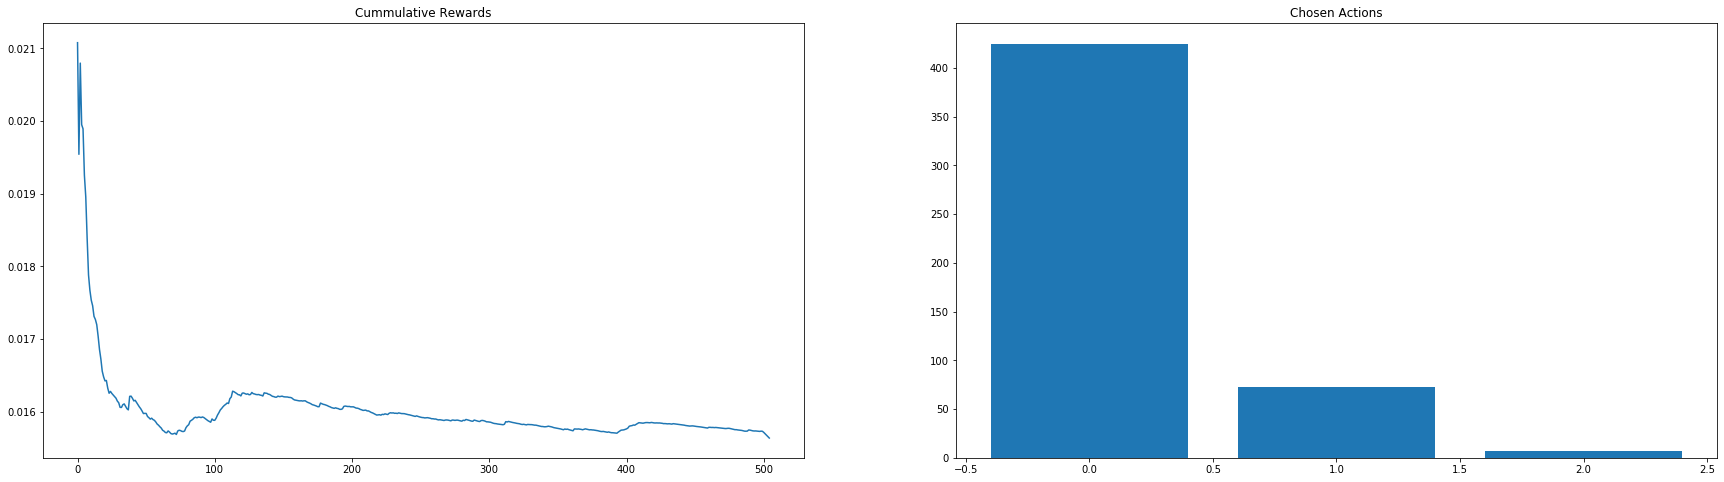

Iteration 1004
Average rewards per algo {'quick_sort': 0.006398816279070267, 'merge_sort': 0.005440846563192669, 'heap_sort': 0.012898099999999838}
Count per chosen algo {'quick_sort': 43, 'merge_sort': 451, 'heap_sort': 6}


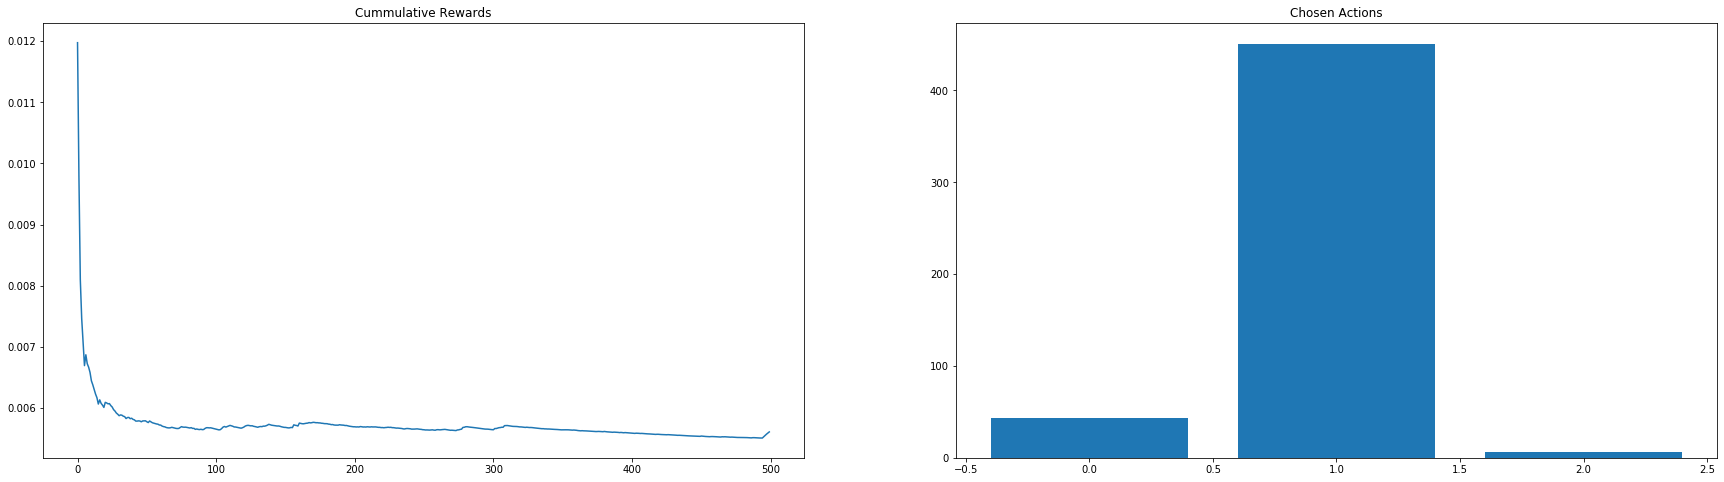

Iteration 1504
Average rewards per algo {'quick_sort': 0.014804198202247596, 'merge_sort': 0.01626072549019518, 'heap_sort': 0.023769424999994015}
Count per chosen algo {'quick_sort': 445, 'merge_sort': 51, 'heap_sort': 4}


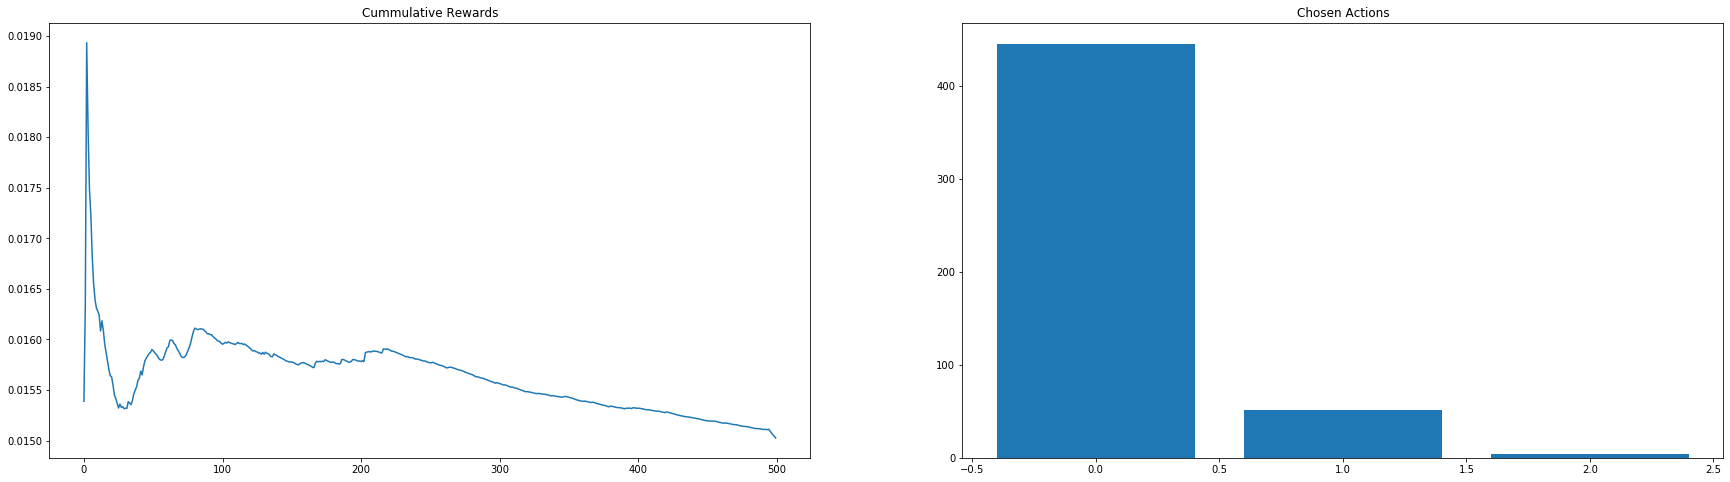

Iteration 1999
Average rewards per algo {'quick_sort': 0.006773734864301279, 'merge_sort': 0.005151814285716634, 'heap_sort': 0.013192844444443748}
Count per chosen algo {'quick_sort': 479, 'merge_sort': 7, 'heap_sort': 9}


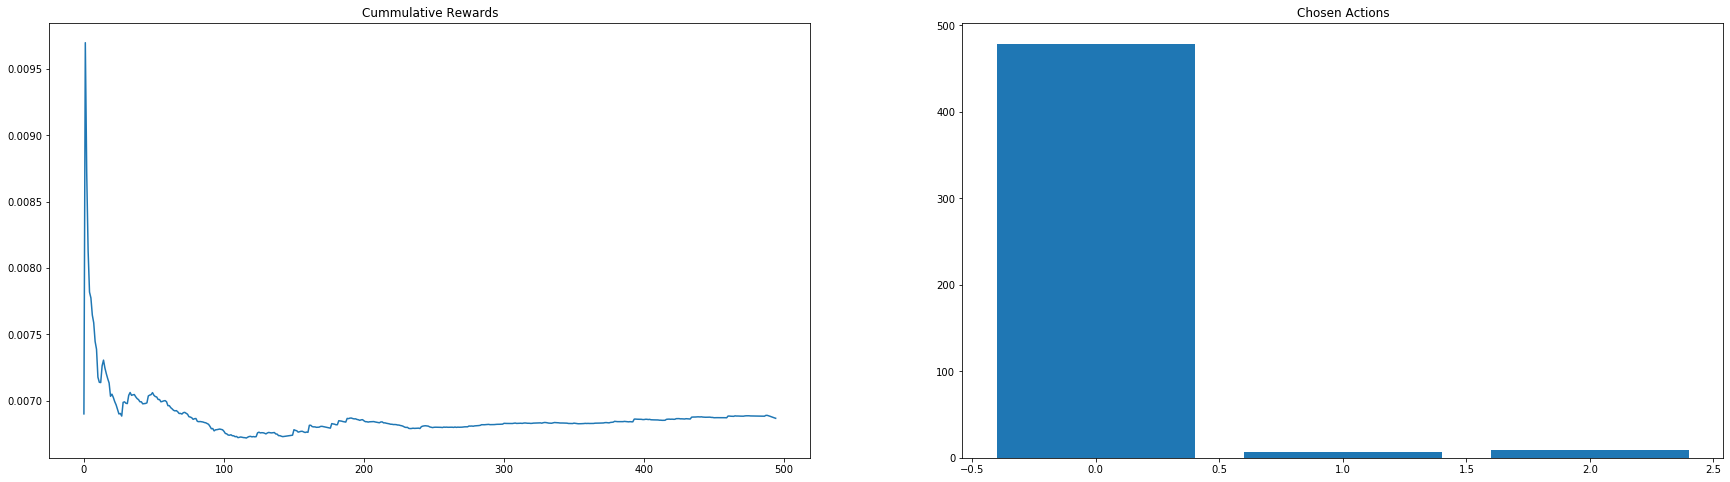

Total reward 21.6141


In [13]:
for elem in list_iteration_results:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward,4))